Reproduced with code from this excellent [blog](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)

In [2]:
#!pip install tensorflow==2.0
#!pip install opencv-python

# 필수 모듈 불러오기
---


In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# annotation file 불러오기
---

In [2]:
import os
os.getcwd()

'C:\\Users\\a3011\\바이오의료(세미나)\\Knee_FRCNN'

In [3]:
annotations_bbox_df = pd.read_csv('annotation_box.csv')

In [4]:
annotations_bbox_df.head()

,Unnamed: 0,ImageID,Image_height,Image_weight,LabelName,XMax,xmax_raw,XMin,xmin_raw,YMax,ymax_raw,YMin,ymin_raw
0,0,X_ray_2020_1.png,1994,2342,Knee_0,0.279675,655,0.168232,394,0.299900,598,0.336510,671
1,1,X_ray_2020_1.png,1994,2342,Knee_1,0.298036,698,0.566610,1327,0.301906,602,0.334504,667
2,2,X_ray_2020_1.png,1994,2342,Knee_2,0.696413,1631,0.154996,363,0.291876,582,0.344534,687
3,3,X_ray_2020_10.png,2384,2558,Knee_0,0.261532,669,0.139953,358,0.243289,580,0.434983,1037
4,4,X_ray_2020_10.png,2384,2558,Knee_1,0.284988,729,0.614934,1573,0.268456,640,0.399748,953


1. **XMin, XMax, YMin, YMax**: coordinates of the box, in normalized image coordinates.
2. **xmin_raw, xmax_raw, ymin_raw, ymax_raw**: original coordinates of the box
3. **LabelName**: 0 is left knee, 1 is right knee, 2 is total knee area

### Plot Bounding box

---

In [5]:
def plot_bbox(img_id):
    img = io.imread('train/'+img_id)
    height, width, channel = img.shape
    print(f"Image: {img.shape}")
    bboxs = annotations_bbox_df[annotations_bbox_df['ImageID']==img_id]
    for index, row in bboxs.iterrows():
        xmin = row['XMin']
        xmax = row['XMax']
        ymin = row['YMin']
        ymax = row['YMax']
        xmin = int(xmin*width)
        xmax = int(xmax*width)
        ymin = int(ymin*height)
        ymax = int(ymax*height)
        label_name = row['LabelName']
        print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
        cv2.rectangle(img, (xmin, ymin), (xmin+xmax, ymin+ymax), (255,0,0), 5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, label_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
    plt.figure(figsize=(15,10))
    plt.title('Image with Bounding Box')
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Image: (1994, 2342, 4)
Coordinates: (393, 671), (654, 597)
Coordinates: (1326, 667), (698, 601)
Coordinates: (362, 687), (1631, 582)


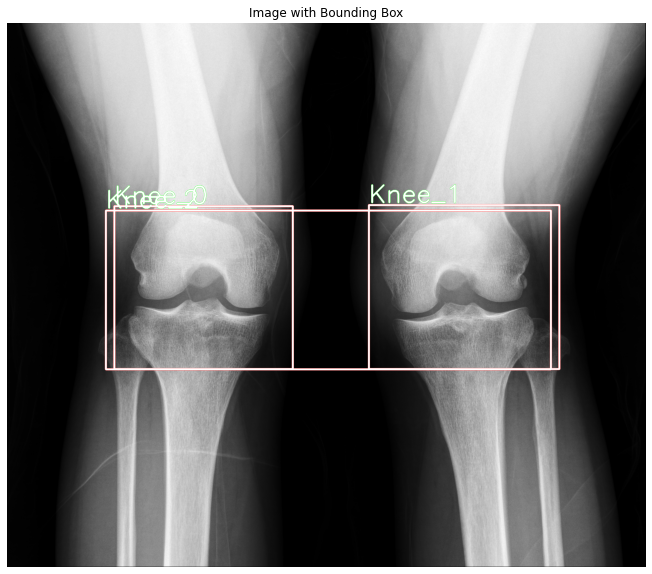

In [6]:
plot_bbox('X_ray_2020_1.png')

In [7]:
img = io.imread('train/X_ray_2020_1.png')

---

---

총 bbox의 수 확인

In [8]:
print('There are %d Knee box in the dataset' %(len(annotations_bbox_df)))

There are 330 Knee box in the dataset


bbox에서 실제 사진의 수

In [9]:
print('There are %d images which contain Knee' % (len(annotations_bbox_df['ImageID'].unique())))

There are 110 images which contain Knee


### Dataset format for Faster-RCNN code

(fname_path, xmin, xmax, ymin, ymax, class_name)

train: 0.8
validation: 0.2

In [10]:
# save images to train and test directory
original_path = 'knee xaray datasets'
train_path = 'train'
test_path = 'test'

In [37]:
# 이미 폴더를 만들었으면 생략
#!mkdir train test

In [11]:
random.seed(12345)

In [12]:
all_imgs = os.listdir('knee xaray datasets')
all_imgs = [f for f in all_imgs if not f.startswith('.')]
random.shuffle(all_imgs)

limit = int(110*0.8)

train_imgs = all_imgs[:limit]
test_imgs = all_imgs[limit:]

# copy each classes' images to train directory
for j in range(len(train_imgs)):
    original_path1 = os.path.join(original_path, train_imgs[j])
    new_path = os.path.join(train_path, train_imgs[j])
    copyfile(original_path1, new_path)

# copy each classes' images to test directory
for j in range(len(test_imgs)):
    original_path1 = os.path.join(original_path, test_imgs[j])
    new_path = os.path.join(test_path, test_imgs[j])
    copyfile(original_path1, new_path)

In [13]:
len(os.listdir('train'))

90

In [14]:
len(os.listdir('test'))

23

The expected number of training images and validation images should be 24 and 6 respectively.

However, there might be some overlap images which appear in two or three classes simultaneously. For instance, an image might be a person walking on the street and there are several cars in the street

In [15]:
train_imgs[0][:train_imgs[0].find('.')]

'X_ray_2020_53'

In [16]:
train_imgs[0].find('.')

13

In [17]:
annotations_bbox_df

,Unnamed: 0,ImageID,Image_height,Image_weight,LabelName,XMax,xmax_raw,XMin,xmin_raw,YMax,ymax_raw,YMin,ymin_raw
0,0,X_ray_2020_1.png,1994,2342,Knee_0,0.279675,655,0.168232,394,0.299900,598,0.336510,671
1,1,X_ray_2020_1.png,1994,2342,Knee_1,0.298036,698,0.566610,1327,0.301906,602,0.334504,667
2,2,X_ray_2020_1.png,1994,2342,Knee_2,0.696413,1631,0.154996,363,0.291876,582,0.344534,687
3,3,X_ray_2020_10.png,2384,2558,Knee_0,0.261532,669,0.139953,358,0.243289,580,0.434983,1037
4,4,X_ray_2020_10.png,2384,2558,Knee_1,0.284988,729,0.614934,1573,0.268456,640,0.399748,953
...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,325,X_ray_2020_98.png,2492,2592,Knee_1,0.271605,704,0.549769,1425,0.298555,744,0.379615,946
326,326,X_ray_2020_98.png,2492,2592,Knee_2,0.680170,1763,0.148148,384,0.313403,781,0.354735,884
327,327,X_ray_2020_99.png,1929,2382,Knee_0,0.293451,699,0.201511,480,0.331778,640,0.353033,681
328,328,X_ray_2020_99.png,1929,2382,Knee_1,0.310243,739,0.574727,1369,0.343701,663,0.309487,597


In [52]:
label_names = ['Knee_0','Knee_1','Knee_2']

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[:img_name.find('.')]
    tmp_df = annotations_bbox_df[annotations_bbox_df['ImageID']==img_id+'.png']
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMin']+row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['XMax']+row['YMax'], 
                                            'ClassName': row['LabelName']}, 
                                           ignore_index=True)


In [53]:
train_df.head()

,FileName,XMin,XMax,YMin,YMax,ClassName
0,X_ray_2020_1.png,0.168232,0.447908,0.336510,0.579575,Knee_0
1,X_ray_2020_1.png,0.566610,0.864646,0.334504,0.599942,Knee_1
2,X_ray_2020_1.png,0.154996,0.851409,0.344534,0.988289,Knee_2
3,X_ray_2020_100.png,0.133224,0.418063,0.388152,0.563353,Knee_0
4,X_ray_2020_100.png,0.594606,0.883122,0.374889,0.588251,Knee_1


In [54]:
train_df.shape

(264, 6)

In [55]:
label_names = ['Knee_0','Knee_1','Knee_2']

test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[:img_name.find('.')]
    tmp_df = annotations_bbox_df[annotations_bbox_df['ImageID']==img_id+'.png']
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                test_df = test_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMin']+row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['XMax']+row['YMax'], 
                                            'ClassName': row['LabelName']}, 
                                           ignore_index=True)

In [56]:
test_df.head()

,FileName,XMin,XMax,YMin,YMax,ClassName
0,X_ray_2020_10.png,0.139953,0.401486,0.434983,0.504821,Knee_0
1,X_ray_2020_10.png,0.614934,0.899922,0.399748,0.553445,Knee_1
2,X_ray_2020_10.png,0.124707,0.891321,0.375000,1.068209,Knee_2
3,X_ray_2020_13.png,0.113242,0.358177,0.379498,0.520289,Knee_0
4,X_ray_2020_13.png,0.656657,0.913169,0.374591,0.535138,Knee_1


In [57]:
test_df.shape

(65, 6)

In [58]:
train_df

,FileName,XMin,XMax,YMin,YMax,ClassName
0,X_ray_2020_1.png,0.168232,0.447908,0.336510,0.579575,Knee_0
1,X_ray_2020_1.png,0.566610,0.864646,0.334504,0.599942,Knee_1
2,X_ray_2020_1.png,0.154996,0.851409,0.344534,0.988289,Knee_2
3,X_ray_2020_100.png,0.133224,0.418063,0.388152,0.563353,Knee_0
4,X_ray_2020_100.png,0.594606,0.883122,0.374889,0.588251,Knee_1
...,...,...,...,...,...,...
259,X_ray_2020_98.png,0.549769,0.821373,0.379615,0.570160,Knee_1
260,X_ray_2020_98.png,0.148148,0.828318,0.354735,0.993573,Knee_2
261,X_ray_2020_99.png,0.201511,0.494962,0.353033,0.625229,Knee_0
262,X_ray_2020_99.png,0.574727,0.884971,0.309487,0.653945,Knee_1


In [59]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

### Write train.csv to annotation.txt

In [60]:
train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
    for idx, row in train_df.iterrows():
        img = cv2.imread('train/' + row['FileName'])
        height, width = img.shape[:2]
        x1 = int(row['XMin'] * width)
        x2 = int(row['XMax'] * width)
        y1 = int(row['YMin'] * height)
        y2 = int(row['YMax'] * height)

        local_file_path = 'train'
        fileName = os.path.join(local_file_path, row['FileName'])
        className = row['ClassName']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [61]:
test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
    for idx, row in test_df.iterrows():
        sys.stdout.write(str(idx) + '\r')
        sys.stdout.flush()
        img = cv2.imread('test/' + row['FileName'])
        height, width = img.shape[:2]
        x1 = int(row['XMin'] * width)
        x2 = int(row['XMax'] * width)
        y1 = int(row['YMin'] * height)
        y2 = int(row['YMax'] * height)

        local_file_path = 'test'
        fileName = os.path.join(local_file_path, row['FileName'])
        className = row['ClassName']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')